<a href="https://colab.research.google.com/github/hamojb/AD_research/blob/main/colab_playaround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from nibabel.testing import data_path
import tensorflow as tf
import nibabel as nib
import os, psutil
from collections import Counter
import nibabel as nib
from scipy import ndimage
from tqdm.notebook import tqdm, trange
import time
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1620895058048689665, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5992056120351355078
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Define Helper Functions

We define a number of functions that will be required in reading and re-structuring the data before we build our CNN models. 

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

def show_slices(slices, col = None):
  """ Function to display row of image slices """
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap=col, origin="lower")
  return

# def read_data(data_path: str): 
#   """ Function to read in data of each brain scan """
#   temp_path = os.path.join(data_path)
#   temp_img = nib.load(temp_path)
#   # return temp_img
#   temp_data = temp_img.get_fdata()
#   return temp_data



# def produce_image(data_path: str): 
#   """ Function to read in data of each brain scan """
#   temp_path = os.path.join(data_path)
#   temp_img = nib.load(temp_path)
#   return temp_img

# def populate_images(oasis_dir):#, df):
#   """ Function to populate data """ 
#   data = []
#   images = []
#   filenames = []
#   for filename in os.listdir(oasis_dir):
#     print(filename)
#     # if file_str in df
#       # new_data, img = read_data(oasis_dir + filename)
#       # data.append(new_data)
#       # images.append(img)
#   return data, images, filenames

# def populate_images(oasis_dir, train_val_test):
#   """ Function to populate data """ 
#   ret_df = {}
#   for filename in os.listdir(oasis_dir):
#     new_str = filename.split(".")[0].split("_")[0]
#     scan = filename.split(".")[0]
#     if new_str in train_val_test:
#       new_data = read_data(oasis_dir + filename)
#       ret_df[scan] = new_data
#     else: 
#       continue
    
#   return ret_df

def match_data(scan_data, diagnosis_data): 
  empty_df = pd.DataFrame()
  scan_patients = list(set(scan_data.Subject.values))
  for patient in scan_patients:
    temp_scans = scan_data[scan_data['Subject'] == patient]
    temp_scans = temp_scans.sort_values('ID')
    temp_diag = diagnosis_data[diagnosis_data['Subject'] == patient]
    temp_diag = temp_diag.sort_values('ID')
    test = pd.merge_asof(temp_scans, temp_diag, on="ID", allow_exact_matches=True, direction = "forward")
    empty_df = empty_df.append(test)
  empty_df = empty_df.drop(columns = ['Inserted_x', 'Inserted_y', 'Subject_y', 'ageAtEntry'])
  empty_df = empty_df.rename(columns = {"Subject_x":"Subject","FS_FSDATA ID":"MRI_ID"})
  empty_df = empty_df.reset_index().drop(columns = ["index"])
  empty_df = empty_df.dropna()
  return empty_df

Quick demonstation on how to read the data in using the `nibabel` package

In [ ]:
path = os.path.join("/content/drive/MyDrive/oasis_original/OAS30001_Freesurfer53_d0129.mgz.nii.gz")
img = nib.load(path)
data = img.get_fdata()

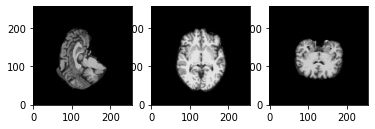

In [ ]:
slice_0 = data[128, :, :]
slice_1 = data[:, 128, :]
slice_2 = data[:, :, 128]
show_slices([slice_0, slice_1, slice_2], "gray")

Define functions to read all data in from `oasis_originals`. 

# Read data and store in variable. 

We initially look to define the original data frame that we will be working in. This requires linking the CDR scores with each scan. There are a few complexities in this process. Most notably: The "days" section of our MRI ID's do not match the "days" for the CDR score. To counter this we have made the assumption that for each patient, it is safe to say that closest diagnosis following an MRI scan is the corresponding diagnosis to said scan. 

Following this, we have begun working on reading our data in according to a number of set rules. Since we have longitudinal data, we must ensure that no patient exists across different training/validation/test sets (Training and non-training being most crucial). 

There are other requirements and these have been documented throughout the process. 

### Clinical Data (Contains CDR score)

In [ ]:
clinical_data = pd.read_csv("/content/drive/MyDrive/extra_data/clinical_data.csv")
clinical_data['ID'] = clinical_data['ADRC_ADRCCLINICALDATA ID'].str.split('_ClinicalData_', 1, expand=True)[1]
clinical_data = clinical_data.drop(columns = ['ADRC_ADRCCLINICALDATA ID', 'Date', 'Subject.1', 'id'])
clinical_data['Inserted'] = pd.to_datetime(clinical_data['Inserted'])
clinical_data['ID'] = clinical_data['ID'].str.extract('(\d+)', expand=False).astype(int)

In [ ]:
clinical_data

,Subject,ageAtEntry,cdr,Inserted,ID
0,OAS30001,65.149895,0.0,2017-12-20 10:54:32.956,0
1,OAS30001,65.149895,0.0,2017-12-20 10:54:33.466,339
2,OAS30001,65.149895,0.0,2017-12-20 10:54:33.673,722
3,OAS30001,65.149895,0.0,2017-12-20 10:54:33.891,1106
4,OAS30001,65.149895,0.0,2017-12-20 10:54:34.117,1456
...,...,...,...,...,...
6219,OAS31172,70.902120,0.0,2017-12-20 14:50:44.860,1215
6220,OAS31172,70.902120,0.0,2017-12-20 14:50:45.131,1565
6221,OAS31172,70.902120,0.0,2017-12-20 14:50:45.404,1908
6222,OAS31172,70.902120,0.0,2017-12-20 14:50:45.679,2816


### Scan Data (contains both scan information and the scan itself)

In [ ]:
scan_info = pd.read_csv("/content/drive/MyDrive/extra_data/freesurfers_mri_info.csv")
scan_info['ID'] = scan_info['FS_FSDATA ID'].str.split('_Freesurfer', 1, expand = True)[1]
scan_info = scan_info.drop(columns = ['Session', 'FS Date'])
scan_info.ID = scan_info.ID.str[3:]
scan_info['Inserted'] = pd.to_datetime(scan_info['Inserted'])
scan_info['ID'] = scan_info['ID'].str.extract('(\d+)', expand=False).astype(int)

In [ ]:
scan_info

,FS_FSDATA ID,Subject,Inserted,ID
0,OAS30001_Freesurfer53_d0129,OAS30001,2017-11-15 13:26:34.150,129
1,OAS30001_Freesurfer53_d0757,OAS30001,2017-12-13 13:44:44.891,757
2,OAS30001_Freesurfer53_d2430,OAS30001,2017-11-15 11:10:13.939,2430
3,OAS30001_Freesurfer53_d3132,OAS30001,2017-10-20 12:44:27.928,3132
4,OAS30002_Freesurfer53_d0653,OAS30002,2017-11-10 12:45:42.205,653
...,...,...,...,...
2042,OAS31168_Freesurfer53_d2526,OAS31168,2017-11-09 14:22:52.248,2526
2043,OAS31169_Freesurfer53_d0620,OAS31169,2017-10-18 15:15:06.880,620
2044,OAS31170_Freesurfer53_d2410,OAS31170,2017-10-18 15:15:06.574,2410
2045,OAS31172_Freesurfer53_d0407,OAS31172,2017-10-18 15:15:06.817,407


### Match Clinical and Scan Data

Here is where we match the data according the previously specified assumption. To debug code see the `Helper Function` section. 

In [ ]:
scan_and_diag = match_data(scan_info, clinical_data)
scans_sorted = scan_and_diag.sort_values(["Subject", "ID"]).reset_index().drop(columns = ["index", "ID"])
scans_sorted

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,0.0
1,OAS30001_Freesurfer53_d0757,OAS30001,0.0
2,OAS30001_Freesurfer53_d2430,OAS30001,0.0
3,OAS30001_Freesurfer53_d3132,OAS30001,0.0
4,OAS30002_Freesurfer53_d0653,OAS30002,0.0
...,...,...,...
1824,OAS31168_Freesurfer53_d2526,OAS31168,0.0
1825,OAS31169_Freesurfer53_d0620,OAS31169,0.5
1826,OAS31170_Freesurfer53_d2410,OAS31170,1.0
1827,OAS31172_Freesurfer53_d0407,OAS31172,0.0


This `ALTERNATIVE_CASE` part isn't exactly necessary. I was initially tossing up between leaving the CDR scores as the raw number for an output but have decided that 'HC', 'MCI' and 'AD' are better classifiers (not that it matters, at all).

In [ ]:
ALTERNATIVE_CASE = True
if ALTERNATIVE_CASE: 
  scans_sorted['cdr'] = scans_sorted['cdr'].astype(str).replace({'0.0':'HC', '0.5': 'MCI', 
                                                                 '1.0': 'AD', '2.0': 'AD', '3.0': 'AD'})
scans_sorted

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,HC
1,OAS30001_Freesurfer53_d0757,OAS30001,HC
2,OAS30001_Freesurfer53_d2430,OAS30001,HC
3,OAS30001_Freesurfer53_d3132,OAS30001,HC
4,OAS30002_Freesurfer53_d0653,OAS30002,HC
...,...,...,...
1824,OAS31168_Freesurfer53_d2526,OAS31168,HC
1825,OAS31169_Freesurfer53_d0620,OAS31169,MCI
1826,OAS31170_Freesurfer53_d2410,OAS31170,MCI
1827,OAS31172_Freesurfer53_d0407,OAS31172,HC


### Populating scan and label lists 

We now have a full data set containing the MRI_ID, Subject and their CDR score. From here, we will begin to populate the data set with scans and labels. The following steps get quite tricky given the previously mentioned specifications. 

We will first obtain a list of the scans that exist within our repository as there are some scans in the above data frame which do not exist in the original data and can, obviously, not be used to train or test the model. 


In [ ]:
lst_scans = list(os.listdir(r'/content/drive/MyDrive/oasis_original/'))
our_scans =[] 
for i in lst_scans: 
  our_scans.append(i.split('.')[0])

We know it runs now... as such, I will just run everything on the first 10% of the data. To run it on all the data just remove the cell below. 

In [ ]:
our_scans = our_scans[:int(0.25*len(our_scans))]

In [ ]:
copy_scans_sorted = scans_sorted.copy()
copy_scans_sorted = copy_scans_sorted[copy_scans_sorted['MRI_ID'].isin(our_scans)]
copy_scans_sorted['MRI_ID'] = '/content/drive/MyDrive/oasis_original/' + copy_scans_sorted['MRI_ID'] + ".mgz.nii.gz"
cdr_HC = copy_scans_sorted[copy_scans_sorted['cdr'] == 'HC']
cdr_MCI = copy_scans_sorted[copy_scans_sorted['cdr'] == 'MCI']
cdr_AD = copy_scans_sorted[copy_scans_sorted['cdr'] == 'AD']

HC_scan_paths = list(cdr_HC['MRI_ID'].values)
MCI_scan_paths = list(cdr_MCI['MRI_ID'].values)
AD_scan_paths = list(cdr_AD['MRI_ID'].values)

print("MRI scans of AD cases: {}".format(str(len(AD_scan_paths))))
print("MRI scans of MCI cases: {}".format(str(len(MCI_scan_paths))))
print("MRI scans of HC cases: {}".format(str(len(HC_scan_paths))))

MRI scans of AD cases: 3
MRI scans of MCI cases: 99
MRI scans of HC cases: 343


We see we have 20 AD, 348 MCI a 1456 HC cases; however, we need to determine how many subjects we have of each too. As such we will split the data on the subjects rather than the scan itself. This ensures that we will not violate the requirements from previously. 

In [ ]:
from random import shuffle
subj_ids = list(set(copy_scans_sorted["Subject"]))
shuffle(subj_ids)
len(subj_ids)

244

In [ ]:
train_num_subs = int(len(subj_ids)*.6)
valid_num_subs = int(len(subj_ids)*.2)
test_num_subs = int(len(subj_ids)*.2)
print("Desired training patients: {}".format(train_num_subs))
print("Desired validation patients: {}".format(valid_num_subs))
print("Desired test patients: {}".format(test_num_subs))

Desired training patients: 146
Desired validation patients: 48
Desired test patients: 48


In [ ]:
ad_subjs = cdr_AD.Subject.values
use_this_val = len(list(set(ad_subjs)))

Next, we ensure that we always have AD cases even when using a subset of the data. 

Using the full data set, this will split to ensure we have 12 cases for training, 4 cases for validation and 4 cases for testing. 

In [ ]:
training_subjs = list(ad_subjs[:int(use_this_val * 0.6)])
validation_subjs = list(ad_subjs[int(use_this_val * 0.6):int(use_this_val * 0.8)])
test_subjs = list(ad_subjs[int(use_this_val * 0.8):])

In [ ]:
union = list(set().union(training_subjs, validation_subjs, test_subjs)) 
for i in subj_ids: 
  if i not in union: 
    if len(test_subjs) < test_num_subs: 
      test_subjs.append(i)
    elif len(validation_subjs) < valid_num_subs: 
      validation_subjs.append(i)
    else: 
      training_subjs.append(i)
    union.append(i)

In [ ]:
cdr_HC = copy_scans_sorted[copy_scans_sorted['cdr'] == 'HC']
cdr_MCI = copy_scans_sorted[copy_scans_sorted['cdr'] == 'MCI']
cdr_AD = copy_scans_sorted[copy_scans_sorted['cdr'] == 'AD']

In [ ]:
training_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(training_subjs)]
validation_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(validation_subjs)]
test_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(test_subjs)]

In [ ]:
def return_scan_paths(data, data_def:str):
  cdr_HC = data[data['cdr'] == 'HC']
  cdr_MCI = data[data['cdr'] == 'MCI']
  cdr_AD = data[data['cdr'] == 'AD']

  HC_scan_paths = list(cdr_HC['MRI_ID'].values)
  MCI_scan_paths = list(cdr_MCI['MRI_ID'].values)
  AD_scan_paths = list(cdr_AD['MRI_ID'].values)

  print("MRI scans of AD cases in {} data: {}".format(data_def, str(len(AD_scan_paths))))
  print("MRI scans of MCI cases in {} data: {}".format(data_def, str(len(MCI_scan_paths))))
  print("MRI scans of HC cases in {} data: {}".format(data_def, str(len(HC_scan_paths))))
  return HC_scan_paths, MCI_scan_paths, AD_scan_paths

In [ ]:
train_HC, train_MCI, train_AD = return_scan_paths(training_data, 'training')

MRI scans of AD cases in training data: 1
MRI scans of MCI cases in training data: 63
MRI scans of HC cases in training data: 196


In [ ]:
val_HC, val_MCI, val_AD = return_scan_paths(validation_data, 'validation')

MRI scans of AD cases in validation data: 1
MRI scans of MCI cases in validation data: 17
MRI scans of HC cases in validation data: 76


In [ ]:
test_HC, test_MCI, test_AD = return_scan_paths(test_data, 'test')

MRI scans of AD cases in test data: 1
MRI scans of MCI cases in test data: 19
MRI scans of HC cases in test data: 71


In [ ]:
def split_HC(lst): 
  return lst[:int(len(lst) * 5)]
train_HC = split_HC(train_HC)
val_HC = split_HC(val_HC)


In [ ]:
def return_labels(data):
  cdr_HC = data[data['cdr'] == 'HC']
  cdr_MCI = data[data['cdr'] == 'MCI']
  cdr_AD = data[data['cdr'] == 'AD']

  HC_labels = list(cdr_HC['cdr'].values)
  MCI_labels = list(cdr_MCI['cdr'].values)
  AD_labels = list(cdr_AD['cdr'].values)
  ydata = np.concatenate((HC_labels, MCI_labels, AD_labels))
  dummies = pd.get_dummies(ydata, columns=["Bridge_Types"], prefix=["Type_is"] )
  return HC_labels, MCI_labels, AD_labels

These may already exist; they do not take too long to run if they do so I am just leaving this code in here for now. No harm done. 

In [ ]:
!pip install tqdm
!pip install ipywidgets

We (finally) populate our data. This takes a bloody age do be prepared to sit there and try and run this over night if possible. Once it is working we will use subsets of this to speed it all up. 

In [ ]:
train_HC_scans = np.array([process_scan(path) for path in tqdm(train_HC)])
train_MCI_scans = np.array([process_scan(path) for path in tqdm(train_MCI)])
train_AD_scans = np.array([process_scan(path) for path in tqdm(train_AD)])
x_train = np.concatenate((train_HC_scans, train_MCI_scans, train_AD_scans))

y_train = return_labels(training_data)

In [ ]:
val_HC_scans = np.array([process_scan(path) for path in tqdm(val_HC)])
val_MCI_scans = np.array([process_scan(path) for path in tqdm(val_MCI)])
val_AD_scans = np.array([process_scan(path) for path in tqdm(val_AD)])
x_val = np.concatenate((val_HC_scans, val_MCI_scans, val_AD_scans))

y_val = return_labels(validation_data)

In [ ]:
test_HC_scans = np.array([process_scan(path) for path in tqdm(test_HC)])
test_MCI_scans = np.array([process_scan(path) for path in tqdm(test_MCI)])
test_AD_scans = np.array([process_scan(path) for path in tqdm(test_AD)])
x_test = np.concatenate((test_HC_scans, test_MCI_scans, test_AD_scans))

y_test = return_labels(test_data)

In [ ]:
!pip install timm 
import torch
import timm
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)
model.eval()

     |████████████████████████████████| 376 kB 6.5 MB/s 


Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_384-8de9b5d1.pth


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [ ]:
y_train = [item for sublist in y_train for item in sublist]
y_val = [item for sublist in y_val for item in sublist]
y_test = [item for sublist in y_test for item in sublist]

len(y_train)

260

We now need to add label encoders for each of the values since we have multiclass labels. I believe 0 = AD, 1 = HC, 2 = MCI but will need to confirm and this may change based on different iterations. (On that note, I will need to set a seed to ensure that we always randomly shuffle the numbers in the same way because everything is so random at the moment). 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

In [ ]:
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0])

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 50
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 128, 128, 64), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
train_loader

<TensorSliceDataset shapes: ((128, 128, 64), ()), types: (tf.float32, tf.int64)>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 52.3 MB/s 
     |████████████████████████████████| 895 kB 55.5 MB/s 
     |████████████████████████████████| 636 kB 34.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline

pipes = pipeline(task = 'feature-extraction', model = 'facebook/deit-small-distilled-patch16-224')

Some weights of the model checkpoint at facebook/deit-small-distilled-patch16-224 were not used when initializing DeiTModel: ['distillation_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.weight', 'deit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

TypeError: ignored

In [ ]:
# https://huggingface.co/models?search=deit

In [ ]:
from tensorflow import keras 
train_datagen = keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(dataframe = train_dataset)

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [ ]:
def benchmark_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model.
    
    Although this will not be a baseline model as such, this is more just 
    to test whether or not the data is structured in such a wway that we know
    subsequent models will run."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model
# Build model.
benchmark = benchmark_model(width=128, height=128, depth=64)
benchmark.summary()

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
benchmark.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
benchmark.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(benchmark.history.history[metric])
    ax[i].plot(benchmark.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
len(x_test)

In [ ]:
benchmark.load_weights("3d_image_classification.h5")
val_preds = []
for i in range(len(x_val)): 
  val_preds.append(benchmark.predict(np.expand_dims(x_val[i], axis=0))[0])
# val_preds

In [ ]:
y_val

In [ ]:
np.array(val_preds)

In [ ]:
feature_extractor = tf.keras.applications.Xception(weights="imagenet")
feature_extractor.summary()

In [ ]:
def remove_head(feature_extractor_model):
    model_input = feature_extractor_model.input
    output = feature_extractor_model.get_layer(name='avg_pool').output
    model = tf.keras.Model(inputs=model_input, outputs=output)
    return model
feature_extractor = remove_head(feature_extractor)
feature_extractor.summary()

In [ ]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])
    
    return model

In [ ]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

In [ ]:
def freeze_pretrained_weights(model):
    model.get_layer(name='model_1').trainable=False
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen)
    
    return history

In [ ]:
history_frozen_new_model = train_model(frozen_new_model, train_dataset, validation_dataset, 50)

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(validation_dataset, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

In [ ]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.2)
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("original images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [ ]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training')
benchmark_model_aug = benchmark_model
history_augmented = train_model(benchmark_model_aug, train_generator_aug, validation_generator_aug, epochs=150)
